Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

Подберите параметры модели SARIMAX для этого ряда.

Сделайте вывод о том, как изменилась модель по сравнению с недельной.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from random import random

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_m = data.resample('M').mean()

C:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


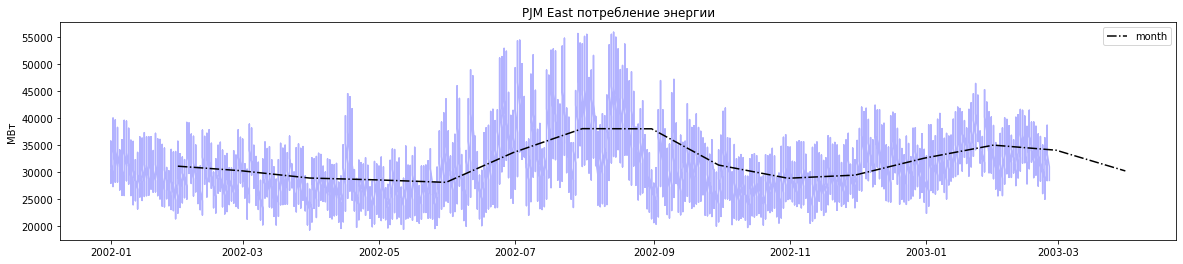

In [4]:
plt.figure(figsize =(20,4))
plt.plot( data.index[:5*24*7*4*3], data['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3)
plt.plot( data_m.index[:5*3], data_m['PJME_MW'].values[:5*3], '-.k',label='month')
plt.title('PJM East потребление энергии')
plt.ylabel('МВт')
plt.legend()
plt.show()

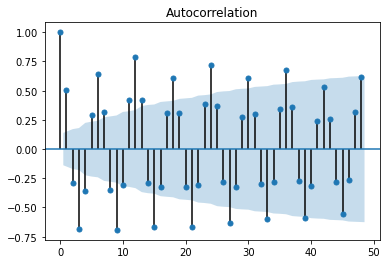

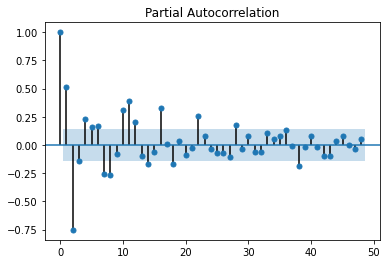

In [5]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=24*2)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=24*2)
plt.show()

In [6]:
import warnings

# Определим p, d и q 
q = 2
p = 2
d = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
# берем месячные данные, тогда сезонность это 12 месяцев
qs = 1
ps = 0
ds = 0
seasonal_pdq = [ps, ds, qs ,12] 

In [7]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [2, 2, 2]    : ps,ds,qs, S= [0, 0, 1, 12]


In [8]:
#для построения модели используем все данные, кроме 6 последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-6],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[2, 2, 2]x[0, 0, 1, 12] - AIC:3221.625491917086


In [9]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  194
Model:             SARIMAX(2, 2, 2)x(0, 0, 1, 12)   Log Likelihood               -1604.813
Date:                            Thu, 16 Apr 2020   AIC                           3221.625
Time:                                    02:13:36   BIC                           3240.682
Sample:                                         0   HQIC                          3229.354
                                            - 194                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

Анализ результатов по results:

Наиболее важные коэффициенты модели, это коэффициенты сглаживания ma.L1, ma.L2 , ma.S.L24. Коэффициенты регрессии, также имеют большой вес ar.L1 и ar.L2. Можно предположить, что нма удалось с ходу подобрать удачные параметры. Однако сначала посмотрим на остатки ряда.

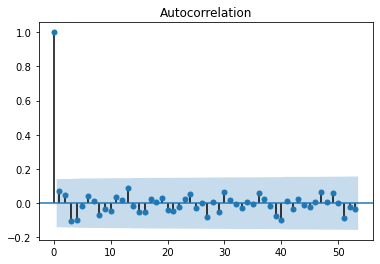

In [10]:
sm.graphics.tsa.plot_acf(results.resid, lags=53)
plt.show()

Остатки крайне не значительны, но пока не будем торопиться с выводами и оценим близости распределений остатков модели к нормальному закону используя визуализацию plot_diagnostics:
- левый верхний график - остатки ряда
- правый верхний - гистограмма для остатков ряда
- левый нижний - упорядоченное распределение остатков (квантильное)
- правый нижний - коррелограмма остатков

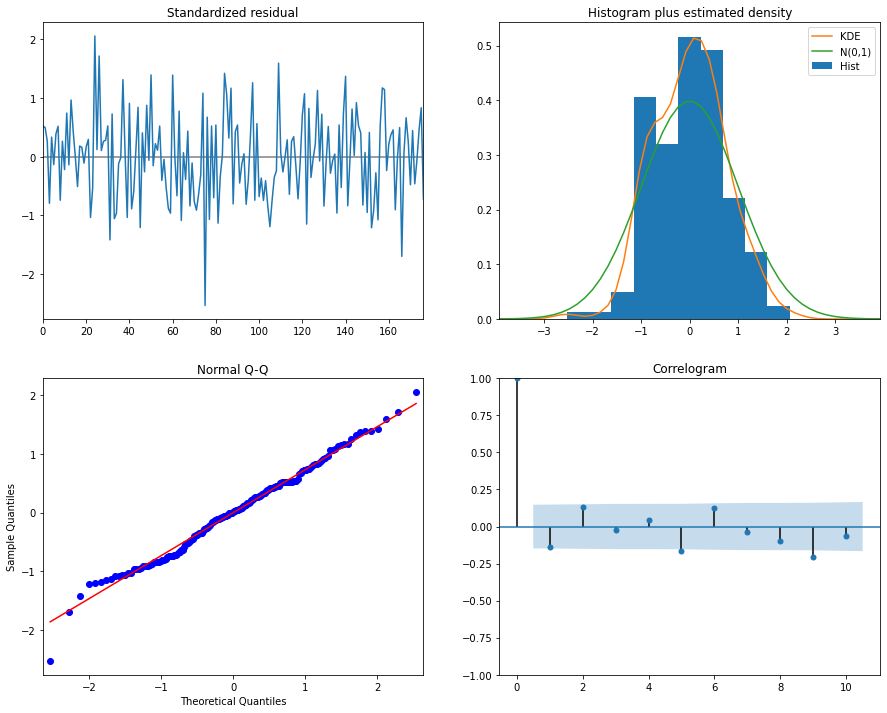

In [11]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

В этом случае диагностика показала, что остатки модели правильно распределяются:
- estimated density показывает, что остатки нормально распределены.
- График q-q в левом нижнем углу показывает, что упорядоченное распределение остатков (синие точки) следует линейному тренду выборок, взятых из стандартного распределения N (0, 1).
- Остатки с течением времени (верхний левый график) не очень похожи на белый шум т.к. имеют некоторые выбросы. График автокорреляции показывает, что остатки временных рядов имеют низкую корреляцию с запаздывающими данными, но мы можем видеть на 5 и 9 лаге, что автокорреляция выходит за границы незначительных значений, значит с нашими параметрами не все так хорошо, как показалось на первый взгляд.

Используем сетойный выбор, чтобы наверняка определить наилучшие параметры для нашей модели.

In [12]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = q = range(0, 3)
d = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = range(0, 3)
d = [0,1]
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [13]:
data_m['PJME_MW'].values.shape

(200,)

In [32]:
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-10],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)3 - AIC:4463.051035665778
ARIMA(0, 0, 0)x(0, 0, 1, 12)3 - AIC:4060.7444686449508
ARIMA(0, 0, 0)x(0, 0, 2, 12)3 - AIC:3759.542088415784
ARIMA(0, 0, 0)x(0, 1, 0, 12)3 - AIC:3189.1047595620003
ARIMA(0, 0, 0)x(0, 1, 1, 12)3 - AIC:2962.900917204553
ARIMA(0, 0, 0)x(0, 1, 2, 12)3 - AIC:2730.1055290308886
ARIMA(0, 0, 0)x(1, 0, 0, 12)3 - AIC:3211.259039000882
ARIMA(0, 0, 0)x(1, 0, 1, 12)3 - AIC:3191.049774025445
ARIMA(0, 0, 0)x(1, 0, 2, 12)3 - AIC:2941.915382582244
ARIMA(0, 0, 0)x(1, 1, 0, 12)3 - AIC:2972.189893609415
ARIMA(0, 0, 0)x(1, 1, 1, 12)3 - AIC:2955.2479807477694
ARIMA(0, 0, 0)x(1, 1, 2, 12)3 - AIC:2722.4468625683667
ARIMA(0, 0, 0)x(2, 0, 0, 12)3 - AIC:2973.294378691268
ARIMA(0, 0, 0)x(2, 0, 1, 12)3 - AIC:2975.49490491147
ARIMA(0, 0, 0)x(2, 0, 2, 12)3 - AIC:2930.070883617009
ARIMA(0, 0, 0)x(2, 1, 0, 12)3 - AIC:2741.113075753251
ARIMA(0, 0, 0)x(2, 1, 1, 12)3 - AIC:2737.695522046629
ARIMA(0, 0, 0)x(2, 1, 2, 12)3 - AIC:2722.744746904641
ARIMA(0, 0, 1)x(0, 0, 0,

ARIMA(0, 2, 2)x(1, 0, 1, 12)3 - AIC:3084.2759756827427
ARIMA(0, 2, 2)x(1, 0, 2, 12)3 - AIC:2875.4878658956013
ARIMA(0, 2, 2)x(1, 1, 0, 12)3 - AIC:2984.6498060644467
ARIMA(0, 2, 2)x(1, 1, 1, 12)3 - AIC:2905.699969447406
ARIMA(0, 2, 2)x(1, 1, 2, 12)3 - AIC:2692.3911139337824
ARIMA(0, 2, 2)x(2, 0, 0, 12)3 - AIC:3012.159228556483
ARIMA(0, 2, 2)x(2, 0, 1, 12)3 - AIC:3005.249600125511
ARIMA(0, 2, 2)x(2, 0, 2, 12)3 - AIC:2947.679806355605
ARIMA(0, 2, 2)x(2, 1, 0, 12)3 - AIC:2759.5884099404248
ARIMA(0, 2, 2)x(2, 1, 1, 12)3 - AIC:2745.920137093131
ARIMA(0, 2, 2)x(2, 1, 2, 12)3 - AIC:2694.283884661342
ARIMA(1, 0, 0)x(0, 0, 0, 12)3 - AIC:3622.3124318531886
ARIMA(1, 0, 0)x(0, 0, 1, 12)3 - AIC:3299.9489026931687
ARIMA(1, 0, 0)x(0, 0, 2, 12)3 - AIC:3089.9934601867644
ARIMA(1, 0, 0)x(0, 1, 0, 12)3 - AIC:3167.3438051514504
ARIMA(1, 0, 0)x(0, 1, 1, 12)3 - AIC:2938.183022195668
ARIMA(1, 0, 0)x(0, 1, 2, 12)3 - AIC:2700.2977380551074
ARIMA(1, 0, 0)x(1, 0, 0, 12)3 - AIC:3266.8428630713624
ARIMA(1, 0, 0)x(1

ARIMA(1, 2, 1)x(2, 0, 2, 12)3 - AIC:2904.4366080285713
ARIMA(1, 2, 1)x(2, 1, 0, 12)3 - AIC:2723.6379967351804
ARIMA(1, 2, 1)x(2, 1, 1, 12)3 - AIC:2733.5451798744907
ARIMA(1, 2, 1)x(2, 1, 2, 12)3 - AIC:2715.9084313477842
ARIMA(1, 2, 2)x(0, 0, 0, 12)3 - AIC:3558.317171682066
ARIMA(1, 2, 2)x(0, 0, 1, 12)3 - AIC:3239.504282173235
ARIMA(1, 2, 2)x(0, 0, 2, 12)3 - AIC:2999.8733813743347
ARIMA(1, 2, 2)x(0, 1, 0, 12)3 - AIC:3184.925034996664
ARIMA(1, 2, 2)x(0, 1, 1, 12)3 - AIC:2897.33866492192
ARIMA(1, 2, 2)x(0, 1, 2, 12)3 - AIC:2684.218527801154
ARIMA(1, 2, 2)x(1, 0, 0, 12)3 - AIC:3192.0562142456793
ARIMA(1, 2, 2)x(1, 0, 1, 12)3 - AIC:3095.862534028106
ARIMA(1, 2, 2)x(1, 0, 2, 12)3 - AIC:2921.6717243752355
ARIMA(1, 2, 2)x(1, 1, 0, 12)3 - AIC:2966.959674346474
ARIMA(1, 2, 2)x(1, 1, 1, 12)3 - AIC:2897.857157479513
ARIMA(1, 2, 2)x(1, 1, 2, 12)3 - AIC:2686.037277993485
ARIMA(1, 2, 2)x(2, 0, 0, 12)3 - AIC:2964.683568535976
ARIMA(1, 2, 2)x(2, 0, 1, 12)3 - AIC:2958.1551667785434
ARIMA(1, 2, 2)x(2, 0,

ARIMA(2, 2, 1)x(0, 1, 1, 12)3 - AIC:2915.756841142494
ARIMA(2, 2, 1)x(0, 1, 2, 12)3 - AIC:2670.5013465389616
ARIMA(2, 2, 1)x(1, 0, 0, 12)3 - AIC:3172.3535974023357
ARIMA(2, 2, 1)x(1, 0, 1, 12)3 - AIC:3155.486047168034
ARIMA(2, 2, 1)x(1, 0, 2, 12)3 - AIC:2885.7884772668576
ARIMA(2, 2, 1)x(1, 1, 0, 12)3 - AIC:2926.654325584917
ARIMA(2, 2, 1)x(1, 1, 1, 12)3 - AIC:2903.0818623592754
ARIMA(2, 2, 1)x(1, 1, 2, 12)3 - AIC:2672.1535454862524
ARIMA(2, 2, 1)x(2, 0, 0, 12)3 - AIC:2911.7222353698744
ARIMA(2, 2, 1)x(2, 0, 1, 12)3 - AIC:2975.0656012180198
ARIMA(2, 2, 1)x(2, 0, 2, 12)3 - AIC:2930.842497285349
ARIMA(2, 2, 1)x(2, 1, 0, 12)3 - AIC:2694.7509359671985
ARIMA(2, 2, 1)x(2, 1, 1, 12)3 - AIC:2672.4474023754756
ARIMA(2, 2, 1)x(2, 1, 2, 12)3 - AIC:2671.3622097358057
ARIMA(2, 2, 2)x(0, 0, 0, 12)3 - AIC:3374.3213203202376
ARIMA(2, 2, 2)x(0, 0, 1, 12)3 - AIC:3151.034049247262
ARIMA(2, 2, 2)x(0, 0, 2, 12)3 - AIC:2937.6287465146365
ARIMA(2, 2, 2)x(0, 1, 0, 12)3 - AIC:3175.372386691498
ARIMA(2, 2, 2)x(

Лучшие результаты на недельных данных параметры модели SARIMA(0,1, 2)x(0, 1, 2, 12) - AIC:2636.1243 (для p,q,d,ps,ds,qs из диапазона [0,1,2]).

In [33]:
#для построения модели используем все данные, кроме 8-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-20],order=[0,1,2],
                                seasonal_order=[0,1,2,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 2472.752401004802


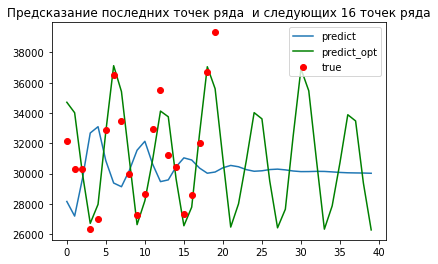

In [34]:
pred_dynamic = results.forecast(40)
pred_dynamic_opt = results_opt.forecast(40)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-20:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 16 точек ряда')
plt.legend()

plt.show()

Видно явное улучшение предсказанных данных по модели для которой мы подобрали коэффициенты перебором в сравнении с моделью, для которй выбрали параметры на угад. Мы видим, что некоторые точки известных данных нашей модели обойти не удалось, но при этом мы видим достаточно точное обхождение действительных точек в предыдущем периоде. 

Если сравнивать недельную модель и месячную, на мой взгляд, месяная модель получилась более точной. Она достаточно точно описывает характер изменений и сезонность.

#### Задание 2

Возмите вариант 1 или 2

- Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
- Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках )
Оцените результат моделирования

Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.

In [108]:
COVID = pd.read_csv('covid_19_data.csv')
COVID.head(10)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
5,6,01/22/2020,Guangdong,Mainland China,1/22/2020 17:00,26.0,0.0,0.0
6,7,01/22/2020,Guangxi,Mainland China,1/22/2020 17:00,2.0,0.0,0.0
7,8,01/22/2020,Guizhou,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
8,9,01/22/2020,Hainan,Mainland China,1/22/2020 17:00,4.0,0.0,0.0
9,10,01/22/2020,Hebei,Mainland China,1/22/2020 17:00,1.0,0.0,0.0


In [109]:
COVID['Data']= pd.to_datetime(COVID['ObservationDate']).dt.date

In [110]:
COVID['Data']= pd.to_datetime(COVID['ObservationDate']).dt.date
COVID = COVID.groupby(['Data','Country/Region'])['Confirmed','Deaths','Recovered'].sum()
COVID.head(20)

Confirmed  Deaths  Recovered
Data       Country/Region                              
2020-01-22 Hong Kong             0.0     0.0        0.0
           Japan                 2.0     0.0        0.0
           Macau                 1.0     0.0        0.0
           Mainland China      547.0    17.0       28.0
           South Korea           1.0     0.0        0.0
           Taiwan                1.0     0.0        0.0
           Thailand              2.0     0.0        0.0
           US                    1.0     0.0        0.0
2020-01-23 Australia             0.0     0.0        0.0
           Brazil                0.0     0.0        0.0
           Colombia              0.0     0.0        0.0
           Hong Kong             2.0     0.0        0.0
           Japan                 1.0     0.0        0.0
           Macau                 2.0     0.0        0.0
           Mainland China      639.0    18.0       30.0
           Malaysia              0.0     0.0        0.0
           Mexico                0.0     0.0        0.0
           Philippines           0.0     0.0        0.0
           Singapore             1.0     0.0        0.0
           South Korea           1.0     0.0        0.0

In [111]:
COV_Italy = COVID.loc[COVID.index.get_level_values( 'Country/Region')=='Italy', ['Confirmed','Deaths','Recovered']]

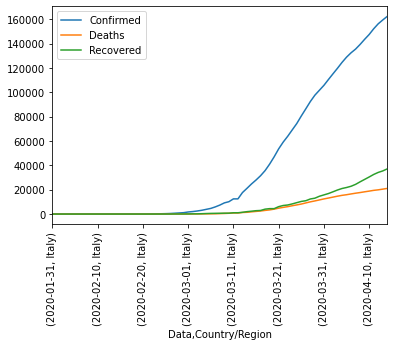

In [112]:
COV_Italy.plot()
plt.xticks(label = COVID.index.get_level_values('Data'), rotation=90)
plt.show()

In [113]:
COV_Italy['Confirmed'].values.shape

(75,)

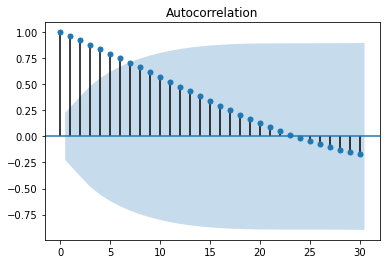

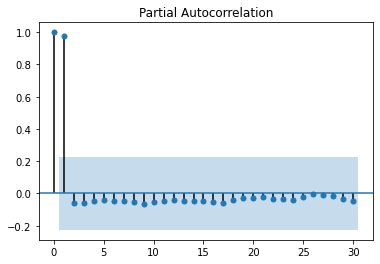

In [114]:
sm.graphics.tsa.plot_acf(COV_Italy['Confirmed'].values, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(COV_Italy['Confirmed'].values, lags=30)
plt.show()

In [115]:
# Определим p, d и q 
q = 1
p = 1
d = 1
pdq = [p, d, q]


warnings.filterwarnings("ignore") # отключает предупреждения

modb = sm.tsa.statespace.SARIMAX(COV_Italy['Confirmed'].values[:-15],
                               order=pdq,seasonal_order=[0,0,0,0], trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb = modb.fit()
print('ARIMA{} - AIC:{}'.format(pdq, resultsb.aic))

print(resultsb.summary().tables[0],resultsb.summary().tables[1])

ARIMA[1, 1, 1] - AIC:927.4840681485767
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -458.742
Date:                Thu, 16 Apr 2020   AIC                            927.484
Time:                        03:01:52   BIC                            937.699
Sample:                             0   HQIC                           931.454
                                 - 60                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -

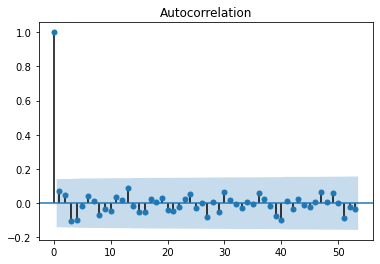

In [116]:
sm.graphics.tsa.plot_acf(results.resid, lags=53)
plt.show()

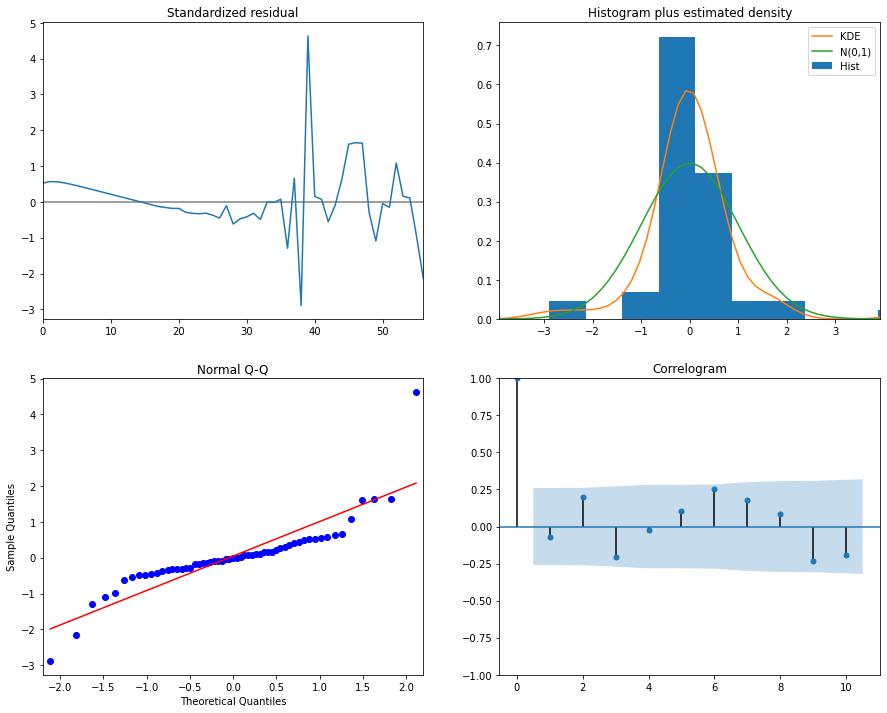

In [117]:
resultsb.plot_diagnostics(figsize=(15, 12))
plt.show()

В этом случае диагностика показала, что остатки модели не правильно распределяются:
- estimated density на верхнем-правом графике красная линия KDE находится близко к линии N (0,1) (где N (0,1) является стандартным обозначением нормального распределения со средним 0 и стандартным отклонением 1). Гистограмма показывает нам, что остатки не нормально распределены.
- График q-q в левом нижнем углу показывает, что упорядоченное распределение остатков (синие точки) не следует линейному тренду выборок, взятых из стандартного распределения N (0, 1).
- Остатки с течением времени (верхний левый график) показывают нам ужасный график, никак не похожий на белый шум
- График автокорреляции (внизу справа), который показывает, что остатки временных рядов имеют низкую корреляцию с запаздывающими данными.

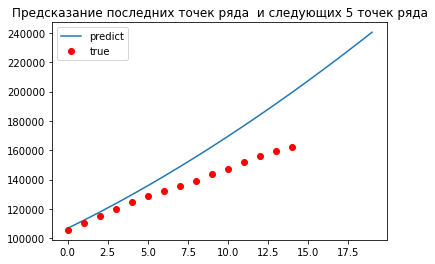

In [118]:
pred_dynamic = resultsb.forecast(20)

plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения 
plt.plot(COV_Italy['Confirmed'].values[-15:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 5 точек ряда')
plt.legend()
plt.plot()
plt.show()

In [129]:
import itertools

d = range(0, 3)
p = range(0, 3)
q = range(0, 7)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [0,0,0,0] # нет сезона

warnings.filterwarnings("ignore") # отключает предупреждения

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod_b = sm.tsa.statespace.SARIMAX(COV_Italy['Confirmed'].values[:-15],
                                          order=param,seasonal_order=[0,0,0,0],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

        results_ = mod_b.fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_.aic))
    except:
        continue

ARIMA(0, 0, 0)x[0, 0, 0, 0] - AIC:1324.4912391076211
ARIMA(0, 0, 1)x[0, 0, 0, 0] - AIC:1265.3270138397909
ARIMA(0, 0, 2)x[0, 0, 0, 0] - AIC:1477.9706460559578
ARIMA(0, 0, 3)x[0, 0, 0, 0] - AIC:1230.3589127826772
ARIMA(0, 0, 4)x[0, 0, 0, 0] - AIC:1325.310976829221
ARIMA(0, 0, 5)x[0, 0, 0, 0] - AIC:1250.5355580438886
ARIMA(0, 0, 6)x[0, 0, 0, 0] - AIC:1197.1632956068395
ARIMA(0, 1, 0)x[0, 0, 0, 0] - AIC:988.4808000205072
ARIMA(0, 1, 1)x[0, 0, 0, 0] - AIC:955.6643481659646
ARIMA(0, 1, 2)x[0, 0, 0, 0] - AIC:918.8757708958409
ARIMA(0, 1, 3)x[0, 0, 0, 0] - AIC:902.0865314828478
ARIMA(0, 1, 4)x[0, 0, 0, 0] - AIC:885.4875495002386
ARIMA(0, 1, 5)x[0, 0, 0, 0] - AIC:873.8344473342294
ARIMA(0, 1, 6)x[0, 0, 0, 0] - AIC:863.4021126402922
ARIMA(0, 2, 0)x[0, 0, 0, 0] - AIC:942.4358966147794
ARIMA(0, 2, 1)x[0, 0, 0, 0] - AIC:911.9786352768449
ARIMA(0, 2, 2)x[0, 0, 0, 0] - AIC:898.6814308430013
ARIMA(0, 2, 3)x[0, 0, 0, 0] - AIC:881.0885081420972
ARIMA(0, 2, 4)x[0, 0, 0, 0] - AIC:858.0977289892401
ARIMA(

Поиск по сетке определяет модель ARIMA(0, 2, 6)- AIC:829.3322557276578

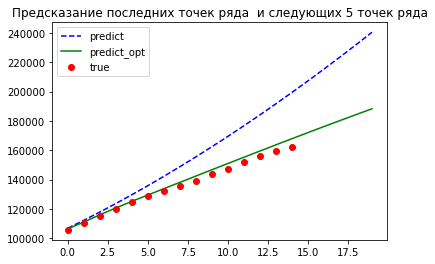

In [141]:
modb_opt = sm.tsa.statespace.SARIMAX(COV_Italy['Confirmed'].values[:-15],
                               order=[0,2,6],seasonal_order=[0,0,0,0],trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb_opt = modb_opt.fit()
pred_dynamic = resultsb.forecast(20)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = resultsb_opt.forecast(20) 

plt.plot(pred_dynamic,'--b', label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(COV_Italy['Confirmed'].values[-15:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 5 точек ряда')
plt.legend()
plt.plot()
plt.show()

In [142]:
pred_dynamic_opt

array([106527.95733325, 111100.26721922, 116054.76926267, 120733.69568802,
       125214.05010378, 129523.20041812, 133831.89049592, 138136.71591386,
       142434.27224863, 146721.15507691, 150993.95997539, 155249.28252076,
       159483.71828971, 163693.86285893, 167876.31180509, 172027.6607049 ,
       176144.50513504, 180223.44067219, 184261.06289304, 188253.96737428])

Улучшенная модель очень хорошо описала действительные значения, однако есть тенденция к завышению. Сейчас данные на 14/04 предсказаны с завышением на 5000, а это довольно много,когда речь идет о количестве заболевших людей. На мой взгляд данных пока еще очень мало для того чтобы можно было качественно обучить модель и сделать точное предсказание. 

##### Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.

Я думаю, что для работы с техниками регрессии на основе ARIMA лучше подходят такие модели у которых изменения данных не предусматривают каких-то выбросов зависимых от третьих факторов, когда есть какой-то логически объяснимый закон изменения. Т.е. лучше будут работать модели, у которых изменения зависят от времени. Например: температура за окном (ночью всегда меньше, чем днем), пробки на дорогах (больше утром и вечером, чем днем и ночью), объем продаж (тут может быть сильная сезонность, зависит от того что продают, и форс-мажоры, тоже могут испортить картину), рост цен и зарплат вне кризисной ситуации. В общем какие-то модели, которые ожидаемо зависят от времени, без скачков и внезапных резких изменений.